In [1]:
from functools import partial
from time import time

import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline

from swimnetworks import Linear
from swimpde.ansatz import BasicAnsatz
from swimpde.domain import Domain

Set parameters of the equation

In [2]:
# True solution for gamma.
def gamma(v):
    return 100.0 * (
        1.0 + 0.25 * np.sum(np.sin(2*np.pi*v), axis=1)
    )

# Solution of the equation for the chosen gamma.
def u_true(v):
    u = 5/2 * np.sin(np.pi * (v - 2/5)) + 3/2 * np.cos(np.pi*(2*v + 3/10))
    return u[:, 0] * u[:, 1]

# Forcing term.
def forcing(v):  
    t_12 = 5.0 / 2.0 * np.sin(np.pi * v[:, 0] - 2 * np.pi / 5.0) + 3.0 / 2.0 * np.cos(
        2 * np.pi * v[:, 0] + 3.0 * np.pi / 10.0
    )
    t_34 = 5.0 / 2.0 * np.sin(np.pi * v[:, 1] - 2 * np.pi / 5.0) + 3.0 / 2.0 * np.cos(
        2 * np.pi * v[:, 1] + 3.0 * np.pi / 10.0
    )
    t_1_xx = (-((np.pi) ** 2)) * (5.0 / 2.0 * np.sin(np.pi * v[:, 0] - 2 * np.pi / 5.0))
    t_2_xx = (-4 * (np.pi) ** 2) * (
        3.0 / 2.0 * np.cos(2 * np.pi * v[:, 0] + 3.0 * np.pi / 10.0)
    )
    t_3_yy = (-((np.pi) ** 2)) * (5.0 / 2.0 * np.sin(np.pi * v[:, 1] - 2 * np.pi / 5.0))
    t_4_yy = (-4 * (np.pi) ** 2) * (
        3.0 / 2.0 * np.cos(2 * np.pi * v[:, 1] + 3.0 * np.pi / 10.0)
    )
    laplacian_u = (t_1_xx + t_2_xx) * t_34 + (t_3_yy + t_4_yy) * t_12
    return laplacian_u - gamma(v) * u_true(v)

x_span = 0, 1.5
n_dim = 2
noise_level = 0

Create data for training and evaluation

In [3]:
# Evaluation data to test the results on.
n_test_sqrt = 101

x_test = np.linspace(*x_span, num=n_test_sqrt)
y_test = np.linspace(*x_span, num=n_test_sqrt)
xy_test = np.stack(np.meshgrid(x_test, y_test), axis=-1)
xy_test = xy_test.reshape(-1, n_dim)
u_test = u_true(xy_test)
gamma_test = gamma(xy_test)

In [4]:
# Measurement points to use for training.
n_measurement_points = 300

rng = np.random.default_rng(10)
xy_measurement = rng.uniform(*x_span, size=(n_measurement_points, n_dim))
noise = rng.normal(size=n_measurement_points) * noise_level
u_measured = u_true(xy_measurement) * (1 + noise)
u_measured = u_measured.reshape(-1, 1)

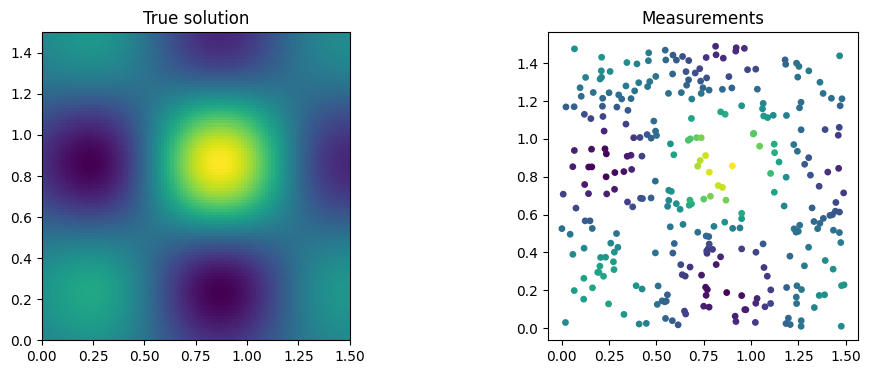

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot the test data.
u_test_square = u_test.reshape(n_test_sqrt, n_test_sqrt)
axes[0].imshow(u_test_square, extent=[*x_span, *x_span], origin="lower")
axes[0].set_title("True solution")

# Plot the measurements.
axes[1].scatter(*xy_measurement.T, c=u_measured, s=15)
axes[1].set_title("Measurements");
axes[1].set_aspect("equal")

In [6]:
# Domain data
n_col_sqrt = 30

x_col = np.linspace(*x_span, num=n_col_sqrt)
y_col = np.linspace(*x_span, num=n_col_sqrt)
xy_col = np.stack(np.meshgrid(x_col, y_col), axis=-1)
xy_col = xy_col.reshape(-1, n_dim)

Define networks to model u and gamma

In [7]:
n_basis = 400
u_seed, gamma_seed = 99, 101

def get_model(points, target, n_basis, seed):
    domain = Domain(interior_points=points)
    ansatz = BasicAnsatz(n_basis=n_basis,
                         activation="tanh",
                         random_seed=seed)
    ansatz.fit(domain, target)
    linear = Linear(regularization_scale=1e-12)
    if target is not None:
        weights = np.linalg.lstsq(
            ansatz.transform(points), target, rcond=1e-12
            )[0]
        linear.weights = weights
    linear.biases = np.zeros((1, 1))
    linear.layer_width = 1
    return ansatz, linear

u_ansatz, u_linear = get_model(xy_measurement, u_measured, n_basis, u_seed)
gamma_ansatz, gamma_linear = get_model(xy_col, None, n_basis, gamma_seed)

Run the alternating least squares to solve the bilinear problem

In [8]:
n_iters = 1


forcing_col = forcing(xy_col)[:, None]
training_start = time()
for _ in range(n_iters):
    u_phi_measured = u_ansatz.transform(xy_measurement)
    u_phi = u_ansatz.transform(xy_col)
    u_approx = u_linear.transform(u_phi)
    gamma_phi = gamma_ansatz.transform(xy_col)
    u_phi_xx = u_ansatz.transform(xy_col, operator="laplace")

    # Least Squares for computing gamma
    matrix_in_gamma = gamma_phi * u_approx
    matrix_out_gamma = u_phi_xx @ u_linear.weights - forcing_col
    gamma_outer_weights = np.linalg.lstsq(
        matrix_in_gamma, matrix_out_gamma, rcond=1e-12
    )[0]

    # Least squares for computing u_approx: use updated value of gamma
    # and also stack the true values we know at the measurement points
    matrix_in_u = (
        u_phi_xx
        - (gamma_phi @ gamma_outer_weights)
        * u_phi
    )
    matrix_in_u = np.row_stack([matrix_in_u, u_phi_measured])
    matrix_out_u = np.concatenate([forcing_col, u_measured])

    u_outer_weights = np.linalg.lstsq(
        matrix_in_u, matrix_out_u, rcond=1e-12
    )[0]

u_linear.weights = u_outer_weights
gamma_linear.weights = gamma_outer_weights

training_time = time() - training_start
print(f"Training time: {training_time}")

Training time: 0.21408295631408691


Evaluate the predictions

In [9]:
u_model = Pipeline([("ansatz", u_ansatz), ("linear", u_linear)])
gamma_model = Pipeline([("ansatz", gamma_ansatz), ("linear", gamma_linear)])

gamma_pred = gamma_model.transform(xy_test).ravel()
u_pred = u_model.transform(xy_test).ravel()

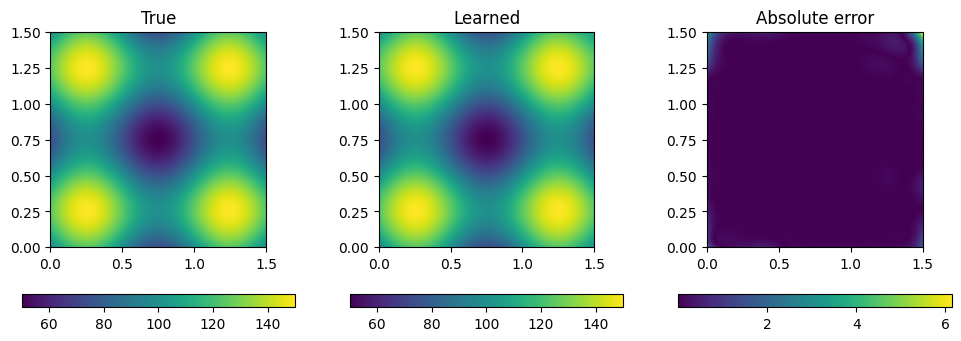

In [10]:
# Visualize predictions of u
data = {"True": gamma_test,
        "Learned": gamma_pred,
        "Absolute error": np.abs(gamma_test - gamma_pred)}

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, label in zip(axes, data):
    squared = data[label].reshape(n_test_sqrt, n_test_sqrt)
    im = ax.imshow(squared, extent=[*x_span, *x_span], origin="lower")
    ax.set_title(label)
    fig.colorbar(im, ax=ax, orientation="horizontal")

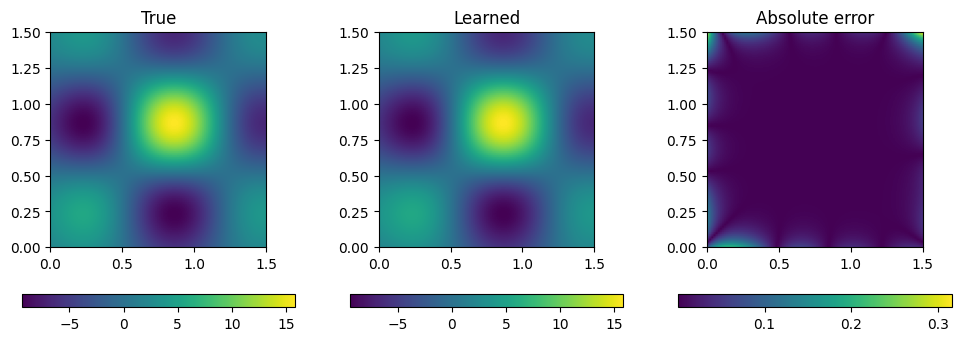

In [11]:
# Visualize predictions of u
data = {"True": u_test,
        "Learned": u_pred,
        "Absolute error": np.abs(u_test - u_pred.ravel())}

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, label in zip(axes, data):
    squared = data[label].reshape(n_test_sqrt, n_test_sqrt)
    im = ax.imshow(squared, extent=[*x_span, *x_span], origin="lower")
    ax.set_title(label)
    fig.colorbar(im, ax=ax, orientation="horizontal")